In [1]:
%pip install --upgrade tensorflow
%pip install --upgrade zeyrek
%pip install --upgrade nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 39.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MONSTER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D, Input, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import re
import zeyrek
from sklearn.preprocessing import MinMaxScaler

In [3]:
analyzer = zeyrek.MorphAnalyzer()

In [4]:
import logging

# Zeyrek kütüphanesinin rulebasedanalyzer logger'ını al
zeyrek_rulebasedanalyzer_logger = logging.getLogger('zeyrek.rulebasedanalyzer')
zeyrek_rulebasedanalyzer_logger.setLevel(logging.CRITICAL)

In [5]:
df = pd.read_csv('testdata.csv', header=None, names=['sentence', 'emotions'])

In [6]:
all_emotions = ["neşeli", "kızgın", "mutlu", "kıskanç", "sürpriz", "üzgün", "heyecanlı", "inatçı", "şaşkın", "korku"]
emotion_dict = {emotion: idx for idx, emotion in enumerate(all_emotions)}

In [7]:
def emotions_to_vector(emotions):
    print(emotions)
    vector = [0] * len(all_emotions)
    for emotion in emotions.split(','):
        if emotion == "emotions":
            continue
        vector[emotion_dict[emotion]] = 1  # Duygunun indeksine karşılık gelen vektör elemanının 1 yapılması
    return vector  # Duygu vektörünün döndürülmesi

df['emotion_vector'] = df['emotions'].apply(emotions_to_vector)

neşeli,heyecanlı,üzgün
mutlu,şaşkın,sürpriz
neşeli,sürpriz,mutlu
mutlu,şaşkın,neşeli
heyecanlı,neşeli,şaşkın
neşeli,üzgün,mutlu
inatçı,heyecanlı,şaşkın
korku,neşeli,mutlu
heyecanlı,şaşkın,mutlu
neşeli,sürpriz,mutlu
şaşkın,mutlu,neşeli
kıskanç,neşeli,üzgün
korku,heyecanlı,şaşkın
neşeli,sürpriz,mutlu
inatçı,şaşkın,heyecanlı
neşeli,kıskanç,mutlu
şaşkın,kızgın,neşeli
mutlu,neşeli,sürpriz
üzgün,kızgın,şaşkın
kıskanç,kızgın,üzgün
üzgün,kızgın,şaşkın
inatçı,kızgın,üzgün
heyecanlı,sürpriz,mutlu
kızgın,neşeli,üzgün
mutlu,kızgın,üzgün
üzgün,korku,şaşkın
kıskanç,kızgın,üzgün
mutlu,sürpriz,heyecanlı
inatçı,kızgın,üzgün
üzgün,kızgın,kıskanç
neşeli,mutlu,kızgın
şaşkın,sürpriz,heyecanlı
mutlu,neşeli,heyecanlı
kıskanç,kızgın,üzgün
üzgün,kızgın,inatçı
şaşkın,korku,sürpriz
heyecanlı,şaşkın,mutlu
neşeli,mutlu,heyecanlı
mutlu,heyecanlı,sürpriz
kıskanç,mutlu,üzgün
heyecanlı,mutlu,neşeli
mutlu,şaşkın,heyecanlı
sürpriz,neşeli,mutlu
inatçı,kıskanç,mutlu
neşeli,mutlu,heyecanlı
mutlu,neşeli,heyecanlı
korku,üzgü

In [8]:
def split_word(sentence): 
    tokens = []
    words = sentence.split()
    for word in words:
        analyses = analyzer.analyze(word)
        for analysis in analyses:
            for parse in analysis:
                try:
                  data=parse.formatted
                  data=data.split(" ")[1]
                  datas=data.split("|")
                  for d in datas:
                      for i in d.split("+"):
                          if ":" in i:
                              tokens.append(i.split(":")[0])
                except:
                    tokens.append(parse.word)  # Hata durumunda kelimeyi olduğu gibi token listesine ekle
                break  # İlk parse
            break  # İlk analiz
    return tokens

# Metni ön işleme tabi tutan fonksiyon
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.strip()
    return text

# Cümleyi kelimelere ayıran ve bu kelimeleri işleyen fonksiyon
def split_sentence(sentence):
    sentence=preprocess_text(sentence)
    words = sentence.split()
    tokens = []
    for word in words:
        tokens.extend(split_word(word))
    return tokens

# DataFrame'deki 'sentence' sütunundaki her bir cümleye split_sentence fonksiyonunun uygulanması
df['tokens'] = df['sentence'].apply(split_sentence)

In [9]:
token_set = set([token for sublist in df['tokens'] for token in sublist])
# Benzersiz token'ları içeren bir sözlük oluştur, her token'a bir indeks atar
token_dict = {token: idx + 1 for idx, token in enumerate(token_set)}

In [10]:
def text_to_token_indices(tokens):
    return [token_dict[token] for token in tokens if token in token_dict]
# DataFrame'e yeni bir sütun ekler ve tokens sütunundaki token listelerini indeks listelerine dönüştürür
df['token_indices'] = df['tokens'].apply(text_to_token_indices)

In [11]:
max_sequence_len = max(len(x) for x in df['token_indices'])
# 'token_indices' sütunundaki her bir diziye padding yapar 
X = pad_sequences(df['token_indices'], maxlen=max_sequence_len)

In [12]:
max_sequence_len = max(len(x) for x in df['token_indices'])
X = pad_sequences(df['token_indices'], maxlen=max_sequence_len)
y = np.array(df['emotion_vector'].tolist())
# Veriyi eğitim ve test setlerine böler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [13]:
# Giriş katmanı
input_layer = Input(shape=(max_sequence_len,))
# Gömme katmanı
embedding_layer = Embedding(input_dim=len(token_dict) + 1, output_dim=512)(input_layer)
# Çift yönlü LSTM katmanı
lstm_layer = Bidirectional(LSTM(512, return_sequences=True))(embedding_layer)
# Çoklu başlıklı dikkat katmanı
attention_layer = MultiHeadAttention(num_heads=4, key_dim=256)(lstm_layer, lstm_layer)
# Küresel maksimum havuzlama katmanı
global_max_pooling_layer = GlobalMaxPooling1D()(attention_layer)
# Tam bağlantılı katman
dense_layer = Dense(128, activation='relu')(global_max_pooling_layer)
# Dropout katmanı
dropout_layer_final = Dropout(0.5)(dense_layer)
# Çıkış katmanı
output_layer = Dense(len(all_emotions), activation='sigmoid')(dropout_layer_final)

# Modeli oluşturma
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.000001, verbose=1)

In [14]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.0985 - loss: 0.5361 - val_accuracy: 0.2561 - val_loss: 0.3774 - learning_rate: 0.0010
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.3461 - loss: 0.3528 - val_accuracy: 0.4903 - val_loss: 0.2680 - learning_rate: 0.0010
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.4958 - loss: 0.2605 - val_accuracy: 0.5281 - val_loss: 0.2289 - learning_rate: 0.0010
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.5306 - loss: 0.2266 - val_accuracy: 0.5500 - val_loss: 0.2229 - learning_rate: 0.0010
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.5344 - loss: 0.2118 - val_accuracy: 0.5444 - val_loss: 0.2231 - learning_rate: 0.0010
Epoch 6/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.5400 - loss: 0.2011 - val_accuracy: 0.5673 - val_loss: 0.2219 - learning_rate: 0.0010
Epoch 7/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.5523 - l

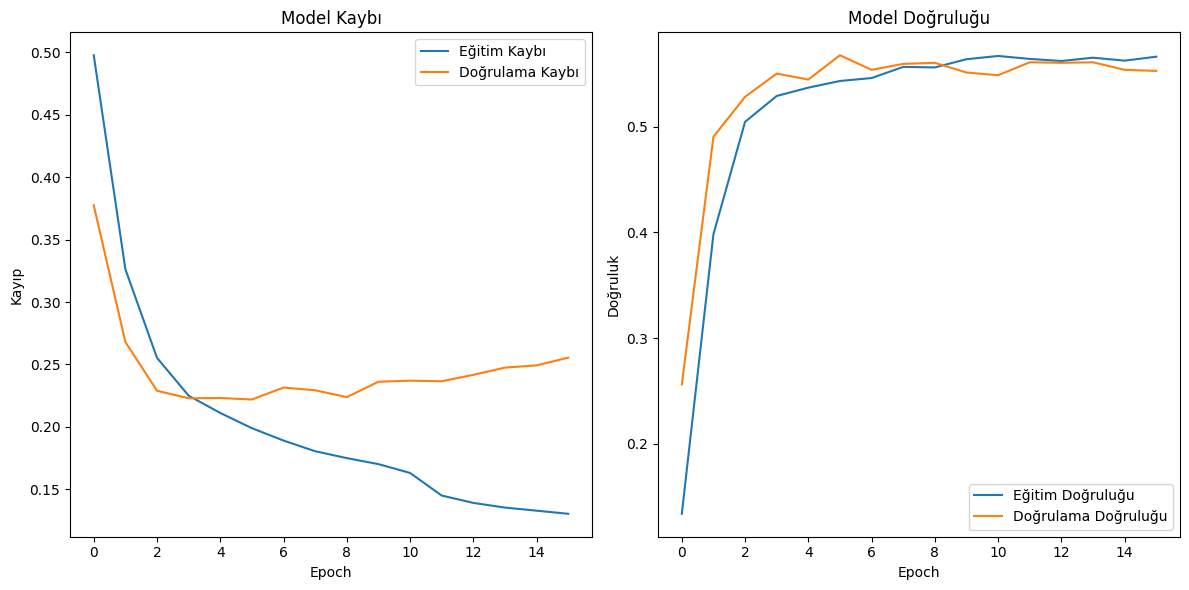

In [16]:
import joblib  # joblib, sklearn ile birlikte gelir ve model/ölçekleyici kaydetme için kullanılır

# Model ve ölçekleyiciyi kaydet
model.save('model4.h5')
with open('tokenizer4.pkl', 'wb') as f:
    joblib.dump(token_dict, f)

# Model Eğitim ve Doğrulama Kaybı ve Doğruluk Grafikleri
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.ylabel('Kayıp')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.ylabel('Doğruluk')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()